In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred, transf_model
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import plot_loss
fmt = mdates.DateFormatter('%d-%b\n%Y')

In [2]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2611606,casos_est_2611606,casos_est_min_2611606,casos_est_max_2611606,p_rt1_2611606,p_inc100k_2611606,temp_min_2611606,temp_max_2611606,umid_min_2611606,pressao_min_2611606,casos_2609600,casos_est_2609600,casos_est_min_2609600,casos_est_max_2609600,p_rt1_2609600,p_inc100k_2609600,temp_min_2609600,temp_max_2609600,umid_min_2609600,pressao_min_2609600
2010-01-03,0,0.0,0,0,0.000000,0.000000,23.566655,29.759870,65.694005,0.996910,0,0.0,0,0,0.000000,0.000000,24.916591,28.483477,72.747520,0.996870
2010-01-10,0,0.0,0,0,0.000000,0.000000,23.361964,28.853036,67.720482,0.997645,0,0.0,0,0,0.000000,0.000000,24.849640,28.135044,72.020724,0.997587
2010-01-17,0,0.0,0,0,0.000000,0.000000,23.713884,28.708514,66.979735,0.999090,0,0.0,0,0,0.000000,0.000000,25.096527,28.133724,71.021156,0.998979
2010-01-24,0,0.0,0,0,0.000000,0.000000,23.133310,28.117144,72.603921,0.997980,0,0.0,0,0,0.000000,0.000000,24.699236,27.566624,75.733819,0.997844
2010-01-31,0,0.0,0,0,0.000000,0.000000,23.832231,29.365596,70.365346,0.996689,0,0.0,0,0,0.000000,0.000000,24.933786,28.324955,75.165093,0.996633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,45,71.0,56,99,0.963845,4.294023,23.319445,29.347922,65.023093,0.997163,1,1.0,1,1,0.617750,0.254379,24.543261,28.324842,71.254825,0.997108
2023-03-26,46,81.0,61,118,0.977543,4.898815,23.407008,28.624516,69.804000,0.998097,2,2.0,2,2,0.845486,0.508757,24.559213,27.799722,76.674585,0.997903
2023-04-02,15,61.0,33,106,0.303912,3.689231,23.293021,29.136257,65.368153,0.997864,0,0.0,0,0,0.000000,0.000000,24.869830,28.264430,71.060175,0.997779
2023-04-09,19,73.5,42,138,0.573956,4.445221,23.688411,28.953186,70.620498,0.996426,0,0.0,0,0,0.000000,0.000000,25.024527,28.156577,74.921788,0.996308


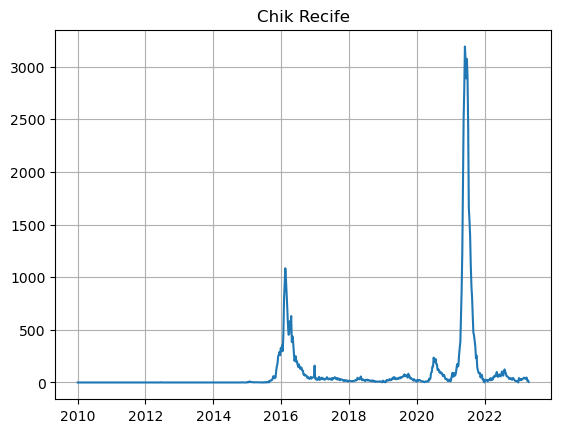

In [4]:
fig, ax = plt.subplots()

ax.plot(df_chik[f'casos_2611606'])

ax.set_title('Chik Recife')
plt.grid()
plt.show()

In [5]:
INI_DATE = '2015-07-01'
END_DATE_TRAIN = '2017-01-01'
END_DATE = '2023-01-01'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 28 # number of features 

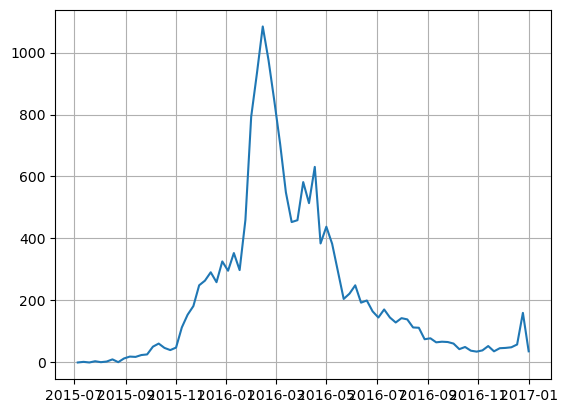

In [6]:
fig, ax = plt.subplots()

ax.plot(df_chik.loc[INI_DATE:END_DATE_TRAIN]['casos_2611606'])

ax.grid()

plt.show()

Apply the dengue model:

2023-05-07 00:21:56.630528: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


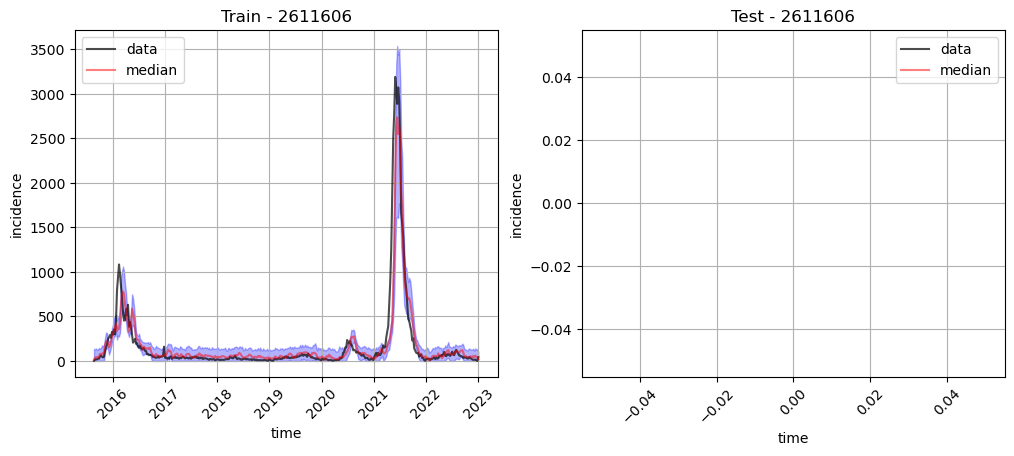

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK, batch_size = 1, 
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA  )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.001821279525756836
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 28)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             2368      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                    

64/64 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 0.2656 - mape: 118.3933 - mse: 0.0102 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mape: 309.2018 - val_mse: 0.0024
Epoch 34/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.2656 - mape: 116.4233 - mse: 0.0083 - val_loss: 0.0023 - val_accuracy: 0.2500 - val_mape: 272.0240 - val_mse: 0.0031
Epoch 35/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 0.3125 - mape: 156.1119 - mse: 0.0112 - val_loss: 0.0070 - val_accuracy: 0.2500 - val_mape: 339.0666 - val_mse: 0.0110
Epoch 36/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.3281 - mape: 142.2307 - mse: 0.0093 - val_loss: 0.0011 - val_accuracy: 0.2500 - val_mape: 116.6248 - val_mse: 0.0011
Epoch 37/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.3438 - mape: 38.2926 - mse: 0.0083 - val_loss: 0.0013 - val_accura

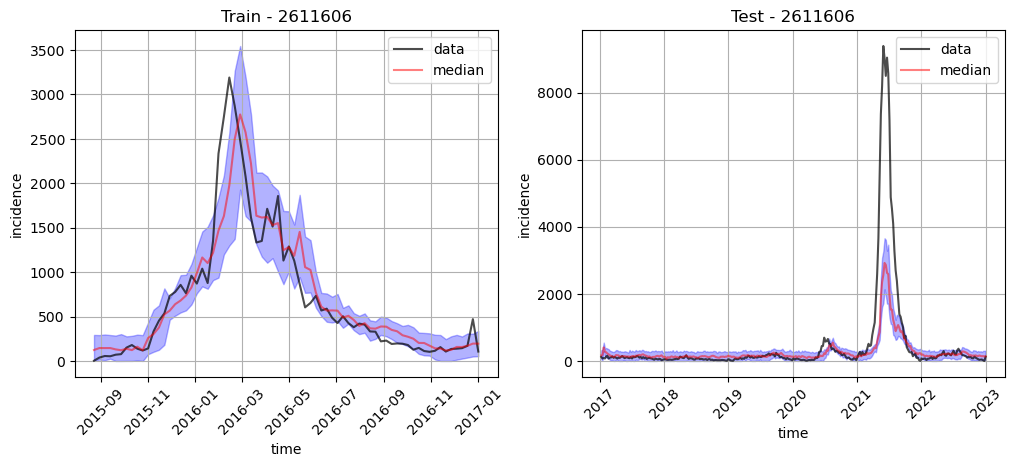

In [8]:

l1 = 1e-6
l2 = 1e-6
BATCH_SIZE = 1
EPOCHS = 100
filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5'
model = transf_model(filename, l1,l2,HIDDEN, FEAT, PREDICT_N, LOOK_BACK, batch_size = BATCH_SIZE, lr = 0.001)
    
m_msle, hist, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE,  epochs= EPOCHS, 
                                predict_n = PREDICT_N, look_back = LOOK_BACK, validation_split = 0.1, monitor = 'val_loss', patience = 20, 
                                label = f'transf_msle', filename_data = FILENAME_DATA,  )

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


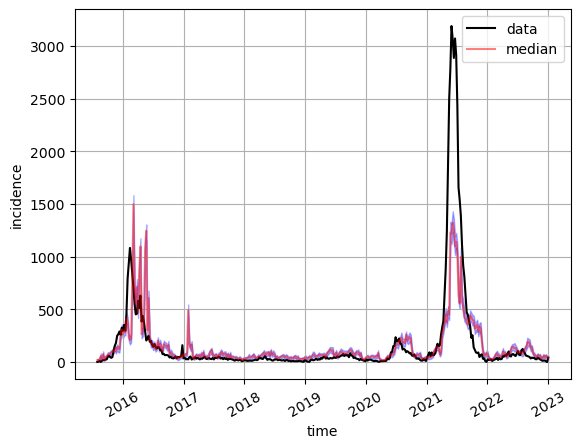

In [9]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA )
    